In [1]:
import os
import pandas as pd
import ftplib
import codecs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime
from zipfile import ZipFile

In [2]:
# Connection Parameters
server = "opendata.dwd.de"
user = "anonymous"
passwd = ""

In [3]:
# FTP Directory Definition and Station Description Filename Pattern
# The topic of interest.
topic_dir_ftp = "/hourly/precipitation/historical/"
topic_dir = "/hourly/precipitation/historical/task4/"

# This is the search pattern common to ALL station description file names
station_desc_pattern = "_Beschreibung_Stationen.txt"

# Below this directory tree node all climate data are stored.
ftp_climate_data_dir = "/climate_environment/CDC/observations_germany/climate/"
ftp_dir = ftp_climate_data_dir + topic_dir_ftp

In [4]:
# Local Directories
local_dir = "../data/"

local_ftp_dir = "../data/original/DWD/"  # Local directory to store local ftp data copies, the local data source or input data.
local_ftp_station_dir = local_ftp_dir + topic_dir  # Local directory where local station info is located
local_ftp_ts_dir = local_ftp_dir + topic_dir  # Local directory where time series downloaded from ftp are located

local_generated_dir = "../data/generated/DWD/"  # The generated of derived data in contrast to local_ftp_dir
local_station_dir = local_generated_dir + topic_dir  # Derived station data, i.e. the CSV file
local_ts_appended_dir = local_generated_dir + topic_dir  # Serially appended time series, long data frame for QGIS TimeManager Plugin

In [5]:
print(local_ftp_dir)
print(local_ftp_station_dir)
print(local_ftp_ts_dir)
print()
print(local_generated_dir)
print(local_station_dir)
print(local_ts_appended_dir)

../data/original/DWD/
../data/original/DWD//hourly/precipitation/historical/task4/
../data/original/DWD//hourly/precipitation/historical/task4/

../data/generated/DWD/
../data/generated/DWD//hourly/precipitation/historical/task4/
../data/generated/DWD//hourly/precipitation/historical/task4/


In [6]:
os.makedirs(local_ftp_dir, exist_ok=True)  # it does not complain if the dir already exists.
os.makedirs(local_ftp_station_dir, exist_ok=True)
os.makedirs(local_ftp_ts_dir, exist_ok=True)

os.makedirs(local_generated_dir, exist_ok=True)
os.makedirs(local_station_dir, exist_ok=True)
os.makedirs(local_ts_appended_dir, exist_ok=True)

In [7]:
# FTP Connect
ftp = ftplib.FTP(server)
res = ftp.login(user=user, passwd=passwd)
print(res)
ret = ftp.cwd(".")

230 Login successful.


In [8]:
# FTP Grab File Function
def grab_file(ftpfullname, localfullname):
    try:
        ret = ftp.cwd(".")  # A dummy action to chack the connection and to provoke an exception if necessary.
        localfile = open(localfullname, 'wb')
        ftp.retrbinary('RETR ' + ftpfullname, localfile.write, 1024)
        localfile.close()

    except ftplib.error_perm:
        print("FTP ERROR. Operation not permitted. File not found?")

    except ftplib.error_temp:
        print("FTP ERROR. Timeout.")

    except ConnectionAbortedError:
        print("FTP ERROR. Connection aborted.")

In [9]:
# Generate Pandas Dataframe from FTP Directory Listing
def gen_df_from_ftp_dir_listing(ftp, ftpdir):
    lines = []
    flist = []
    try:
        res = ftp.retrlines("LIST " + ftpdir, lines.append)
    except:
        print("Error: ftp.retrlines() failed. ftp timeout? Reconnect!")
        return

    if len(lines) == 0:
        print("Error: ftp dir is empty")
        return

    for line in lines:
        [ftype, fsize, fname] = [line[0:1], int(line[31:42]), line[56:]]
        fext = os.path.splitext(fname)[-1]

        if fext == ".zip":
            station_id = int(fname.split("_")[2])
        else:
            station_id = -1

        flist.append([station_id, fname, fext, fsize, ftype])

    df_ftpdir = pd.DataFrame(flist, columns=["station_id", "name", "ext", "size", "type"])
    return (df_ftpdir)

In [10]:
df_ftpdir = gen_df_from_ftp_dir_listing(ftp, ftp_dir)

In [11]:
# Dataframe with TS Zip Files
df_zips = df_ftpdir[df_ftpdir["ext"] == ".zip"]
df_zips.set_index("station_id", inplace=True)  # list of files containing ts
df_zips.head(10)

,name,ext,size,type
station_id,,,,
3,stundenwerte_RR_00003_19950901_20110401_hist.zip,.zip,419296,-
20,stundenwerte_RR_00020_20040814_20201231_hist.zip,.zip,432124,-
44,stundenwerte_RR_00044_20070401_20201231_hist.zip,.zip,354983,-
53,stundenwerte_RR_00053_20051001_20201231_hist.zip,.zip,385830,-
71,stundenwerte_RR_00071_20041022_20200101_hist.zip,.zip,402875,-
73,stundenwerte_RR_00073_20070401_20201231_hist.zip,.zip,357529,-
78,stundenwerte_RR_00078_20041101_20201231_hist.zip,.zip,421522,-
87,stundenwerte_RR_00087_20050201_20201231_hist.zip,.zip,403610,-
91,stundenwerte_RR_00091_20040901_20201231_hist.zip,.zip,419182,-


In [12]:
# Retrieve the Station Description File Name
station_fname = df_ftpdir[df_ftpdir['name'].str.contains(station_desc_pattern)]["name"].values[0]
print(station_fname)

RR_Stundenwerte_Beschreibung_Stationen.txt


In [13]:
# Download the Station Description File
print("grabFile: ")
print("From: " + ftp_dir + station_fname)
print("To:   " + local_ftp_station_dir + station_fname)
grab_file(ftp_dir + station_fname, local_ftp_station_dir + station_fname)

grabFile: 
From: /climate_environment/CDC/observations_germany/climate//hourly/precipitation/historical/RR_Stundenwerte_Beschreibung_Stationen.txt
To:   ../data/original/DWD//hourly/precipitation/historical/task4/RR_Stundenwerte_Beschreibung_Stationen.txt


In [14]:
# extract column names. They are in German (de)
# We have to use codecs because of difficulties with character encoding (German Umlaute)
def station_desc_txt_to_csv(txtfile, csvfile):
    file = codecs.open(txtfile, "r", "utf-8")
    r = file.readline()
    file.close()
    colnames_de = r.split()
    colnames_de

    translate = \
        {'Stations_id': 'station_id',
         'von_datum': 'date_from',
         'bis_datum': 'date_to',
         'Stationshoehe': 'altitude',
         'geoBreite': 'latitude',
         'geoLaenge': 'longitude',
         'Stationsname': 'name',
         'Bundesland': 'state'}

    colnames_en = [translate[h] for h in colnames_de]

    # Skip the first two rows and set the column names.
    df = pd.read_fwf(txtfile, skiprows=2, names=colnames_en, parse_dates=["date_from", "date_to"], index_col=0, encoding='windows-1252')

    # write csv
    df.to_csv(csvfile, sep=";")
    return (df)

In [15]:
# Convert Station Description File.txt to Station Description File.csv
basename = os.path.splitext(station_fname)[0]
df_stations = station_desc_txt_to_csv(local_ftp_station_dir + station_fname, local_station_dir + basename + ".csv")
df_stations.head()

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
3,1995-09-01,2011-04-01,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
20,2004-08-14,2022-03-25,432,48.9219,9.9129,Abtsgmünd-Untergröningen,Baden-Württemberg
29,2006-01-10,2022-03-25,260,49.7175,10.9101,Adelsdorf (Kläranlage),Bayern
44,2007-04-01,2022-03-25,44,52.9336,8.2370,Großenkneten,Niedersachsen
46,2006-01-03,2022-03-25,325,48.9450,12.4639,Aholfing,Bayern


In [16]:
# Select Stations Located in NRW from Station Description Dataframe
station_ids_selected = df_stations[df_stations['state'].str.contains("Nordrhein")].index

# Create variable with TRUE if state is Nordrhein-Westfalen
isNRW = df_stations['state'].str.contains("Nordrhein")

# Create variable with TRUE if date_to is latest date (indicates operation up to now)
#isOperational = df_stations['date_to'] == df_stations.date_to.max()
isOperational = df_stations['date_to'] >= datetime(2018, 1, 1)

# select on both conditions
dfNRW_stations = df_stations[isNRW & isOperational]

# Select only data associated with OE and HSK stations
interested_stations_indices = (dfNRW_stations.index == 216) | (dfNRW_stations.index == 2947) | \
                              (dfNRW_stations.index == 1300) | (dfNRW_stations.index == 2483) | \
                              (dfNRW_stations.index == 3215) | (dfNRW_stations.index == 4488) | \
                              (dfNRW_stations.index == 6264) | (dfNRW_stations.index == 5468) | \
                              (dfNRW_stations.index == 7330)

dfNRW_stations = dfNRW_stations[interested_stations_indices]

In [17]:
dfNRW_stations.shape
#print("Number of stations in NRW: \n", dfNRW.count())

(9, 7)

In [18]:
# Download TS Data from FTP Server
# Add the names of the zip files only to a list.
local_zip_list = []
station_ids_selected = list(dfNRW_stations.index)

for station_id in station_ids_selected:
    try:
        fname = df_zips["name"][station_id]
        print(fname)
        grab_file(ftp_dir + fname, local_ftp_ts_dir + fname)
        local_zip_list.append(fname)
    except:
        print("WARNING: TS file for key %d not found in FTP directory." % station_id)

stundenwerte_RR_00216_20041001_20201231_hist.zip
stundenwerte_RR_01300_20040601_20201231_hist.zip
stundenwerte_RR_02483_19951012_20201231_hist.zip
stundenwerte_RR_02947_20061001_20201231_hist.zip
stundenwerte_RR_03215_20070601_20201231_hist.zip
stundenwerte_RR_04488_20060801_20201231_hist.zip
stundenwerte_RR_05468_20060701_20201001_hist.zip
stundenwerte_RR_06264_20040601_20201231_hist.zip
stundenwerte_RR_07330_20051001_20201231_hist.zip


In [19]:
# Number of obtained stations
len(local_zip_list)
# %%
# Join (Merge) the Time Series Columns
def prec_ts_to_df(fname):
    dateparse = lambda dates: [datetime.strptime(str(d), '%Y%m%d%H') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM", parse_dates=["MESS_DATUM"],
                     date_parser=dateparse, na_values=[-999.0, -999])

    # df = pd.read_csv(fname, delimiter=";", encoding="iso8859_2",\
    #             index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse)

    # https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd

    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return (df)

In [20]:
# Select hourly precipitation data from TS and join it with each other by station_id
# PRECIPITATION
def prec_ts_merge():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0]
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = prec_ts_to_df(myfile)
                s = dftmp["r1"].rename(dftmp["stations_id"][0]).to_frame()
                # outer merge.
                df = pd.merge(df, s, left_index=True, right_index=True, how='outer')

    #df.index.names = ["year"]
    df.index.rename(name="time", inplace = True)
    return(df)

In [21]:
df_merged_ts = prec_ts_merge()

Zip archive: ../data/original/DWD//hourly/precipitation/historical/task4/stundenwerte_RR_00216_20041001_20201231_hist.zip
Extract product file: produkt_rr_stunde_20041001_20201231_00216.txt



D:\Programms\python 3.7.5\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


Zip archive: ../data/original/DWD//hourly/precipitation/historical/task4/stundenwerte_RR_01300_20040601_20201231_hist.zip
Extract product file: produkt_rr_stunde_20040601_20201231_01300.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/task4/stundenwerte_RR_02483_19951012_20201231_hist.zip
Extract product file: produkt_rr_stunde_19951012_20201231_02483.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/task4/stundenwerte_RR_02947_20061001_20201231_hist.zip
Extract product file: produkt_rr_stunde_20061001_20201231_02947.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/task4/stundenwerte_RR_03215_20070601_20201231_hist.zip
Extract product file: produkt_rr_stunde_20070601_20201231_03215.txt

Zip archive: ../data/original/DWD//hourly/precipitation/historical/task4/stundenwerte_RR_04488_20060801_20201231_hist.zip
Extract product file: produkt_rr_stunde_20060801_20201231_04488.txt

Zip archive: ../data/original/DWD//hourly/pre

In [22]:
df_merged_ts.shape

(220182, 9)

In [23]:
# Select indices with the time period of interest
idx = (df_merged_ts.index >= '2018-04-16 00:00:00') & (df_merged_ts.index < '2018-08-16 01:00:00')

In [24]:
# Select rows with the time period of interest, get rid of unnecessary columns
df_merged_ts_ex4 = df_merged_ts[idx]

In [25]:
# Convert hourly data to daily
df_ts_daily = df_merged_ts_ex4.groupby(pd.Grouper(freq='D')).sum()

In [26]:
df_ts_daily.shape

(123, 9)

In [27]:
# Create separate dfs for Olpe (OE) and Hochsauerlandkreis (HSK) counties
df_ts_oe_daily = df_ts_daily[[216, 2947, 5468]]
df_ts_hsk_daily = df_ts_daily[[1300, 2483, 3215, 4488, 6264, 7330]]

In [28]:
# Calculate average precipitation rate for Olpe (OE) and Hochsauerlandkreis (HSK) counties
df_ts_oe_daily_average = df_ts_oe_daily.mean(axis=1).to_frame(name='daily_precp')
df_ts_hsk_daily_average = df_ts_hsk_daily.mean(axis=1).to_frame(name='daily_precp')

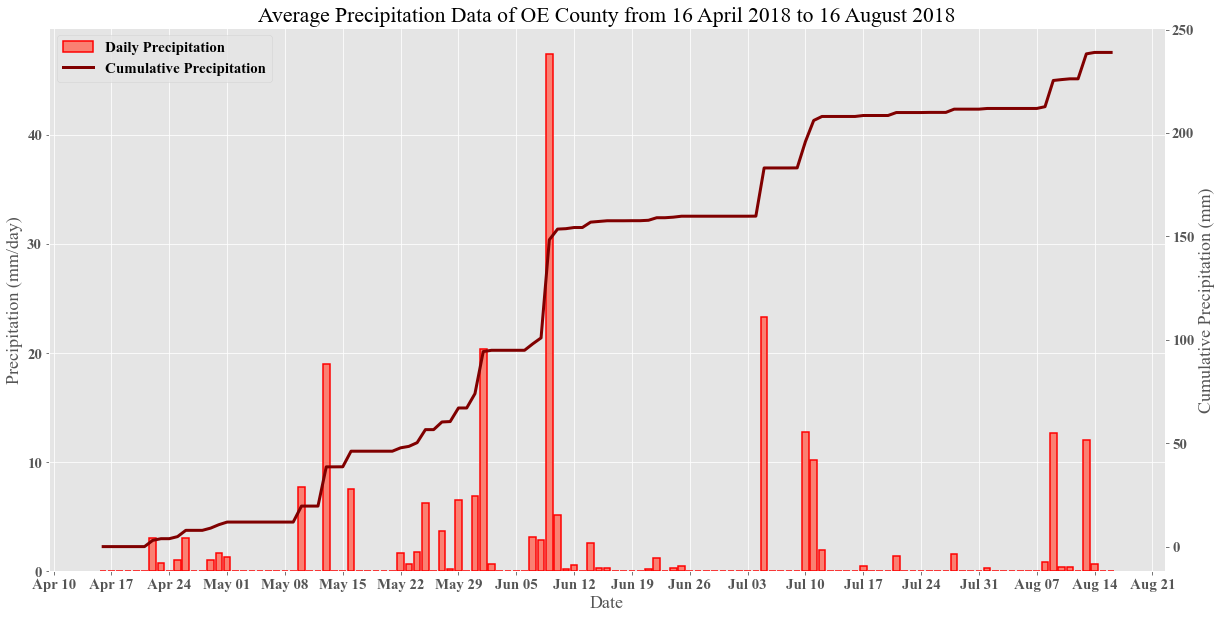

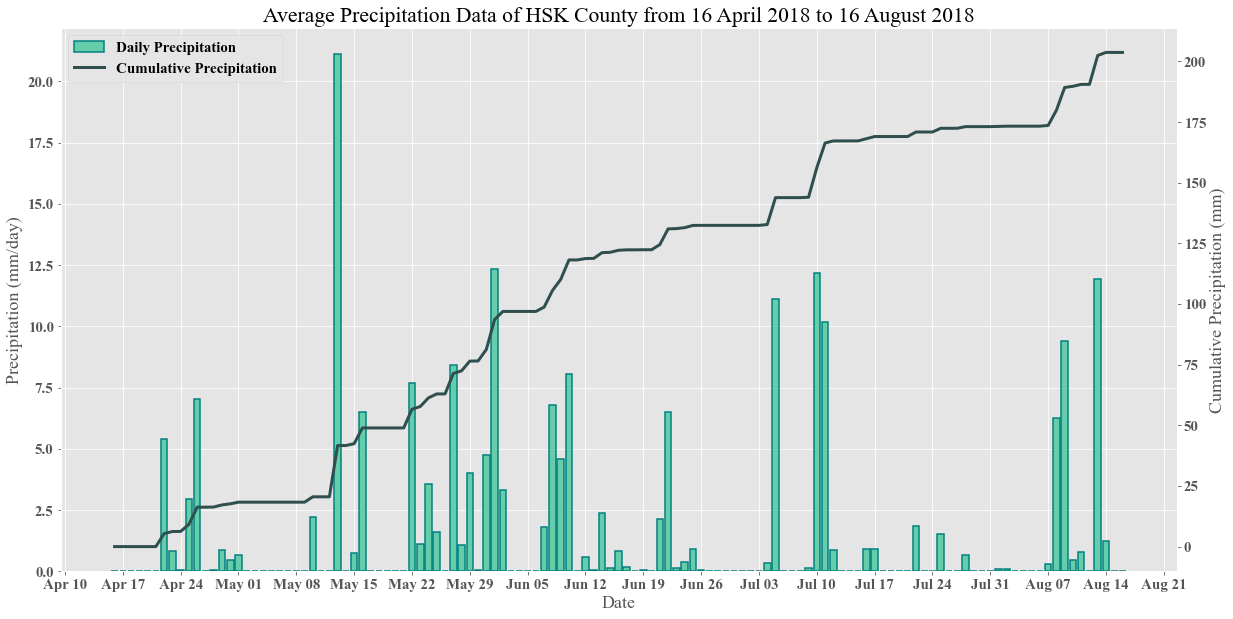

In [29]:
# Plot average precipitation rate for Olpe (OE) and Hochsauerlandkreis (HSK) counties
# Used materials: https://scentellegher.github.io/programming/2017/05/24/pandas-bar-plot-with-formatted-dates.html ,
# https://unidata.github.io/python-training/workshop/Time_Series/basic-time-series-plotting/

def plot_ts_average_bars_line(df, county_name, graph_colors):
    df['cumsum_daily_precp'] = df['daily_precp'].cumsum(axis=0)

    # set ggplot style
    plt.style.use('ggplot')
    font = {'family': 'Times New Roman', 'weight': 'bold', 'size': 15}
    plt.rc('font', **font)
    #plot data
    fig, ax = plt.subplots(figsize=(20, 10))
    axb = ax.twinx()

    ax.set_title('Average Precipitation Data of ' + county_name +
                 ' County from 16 April 2018 to 16 August 2018')
    ax.set_ylabel('Precipitation (mm/day)')
    ax.set_xlabel('Date')

    ax.bar(df.index, df['daily_precp'], linewidth=1.5, color=graph_colors[0], edgecolor=graph_colors[1],
           label='Daily Precipitation')

    axb.set_ylabel('Cumulative Precipitation (mm)')
    axb.plot(df.index, df['cumsum_daily_precp'], linewidth=3.0, color=graph_colors[2],
             label='Cumulative Precipitation')
    axb.grid(None)

    #set ticks every week
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    #format date
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    #ax.set_xlim([date(2018, 4, 16), date(2018, 8, 16)])

    # Handling of getting lines and labels from all axes for a single legend
    bars, labels = ax.get_legend_handles_labels()
    lines2, labels2 = axb.get_legend_handles_labels()
    axb.legend(bars + lines2, labels + labels2, loc='upper left')

    plt.show()

    return df


df_ts_oe_daily_average_cumsum = plot_ts_average_bars_line(df_ts_oe_daily_average, 'OE',
                                                          graph_colors=['salmon', 'red', 'maroon'])
df_ts_hsk_daily_average_cumsum = plot_ts_average_bars_line(df_ts_hsk_daily_average, 'HSK',
                                                           graph_colors=['mediumaquamarine', 'teal', 'darkslategray'])

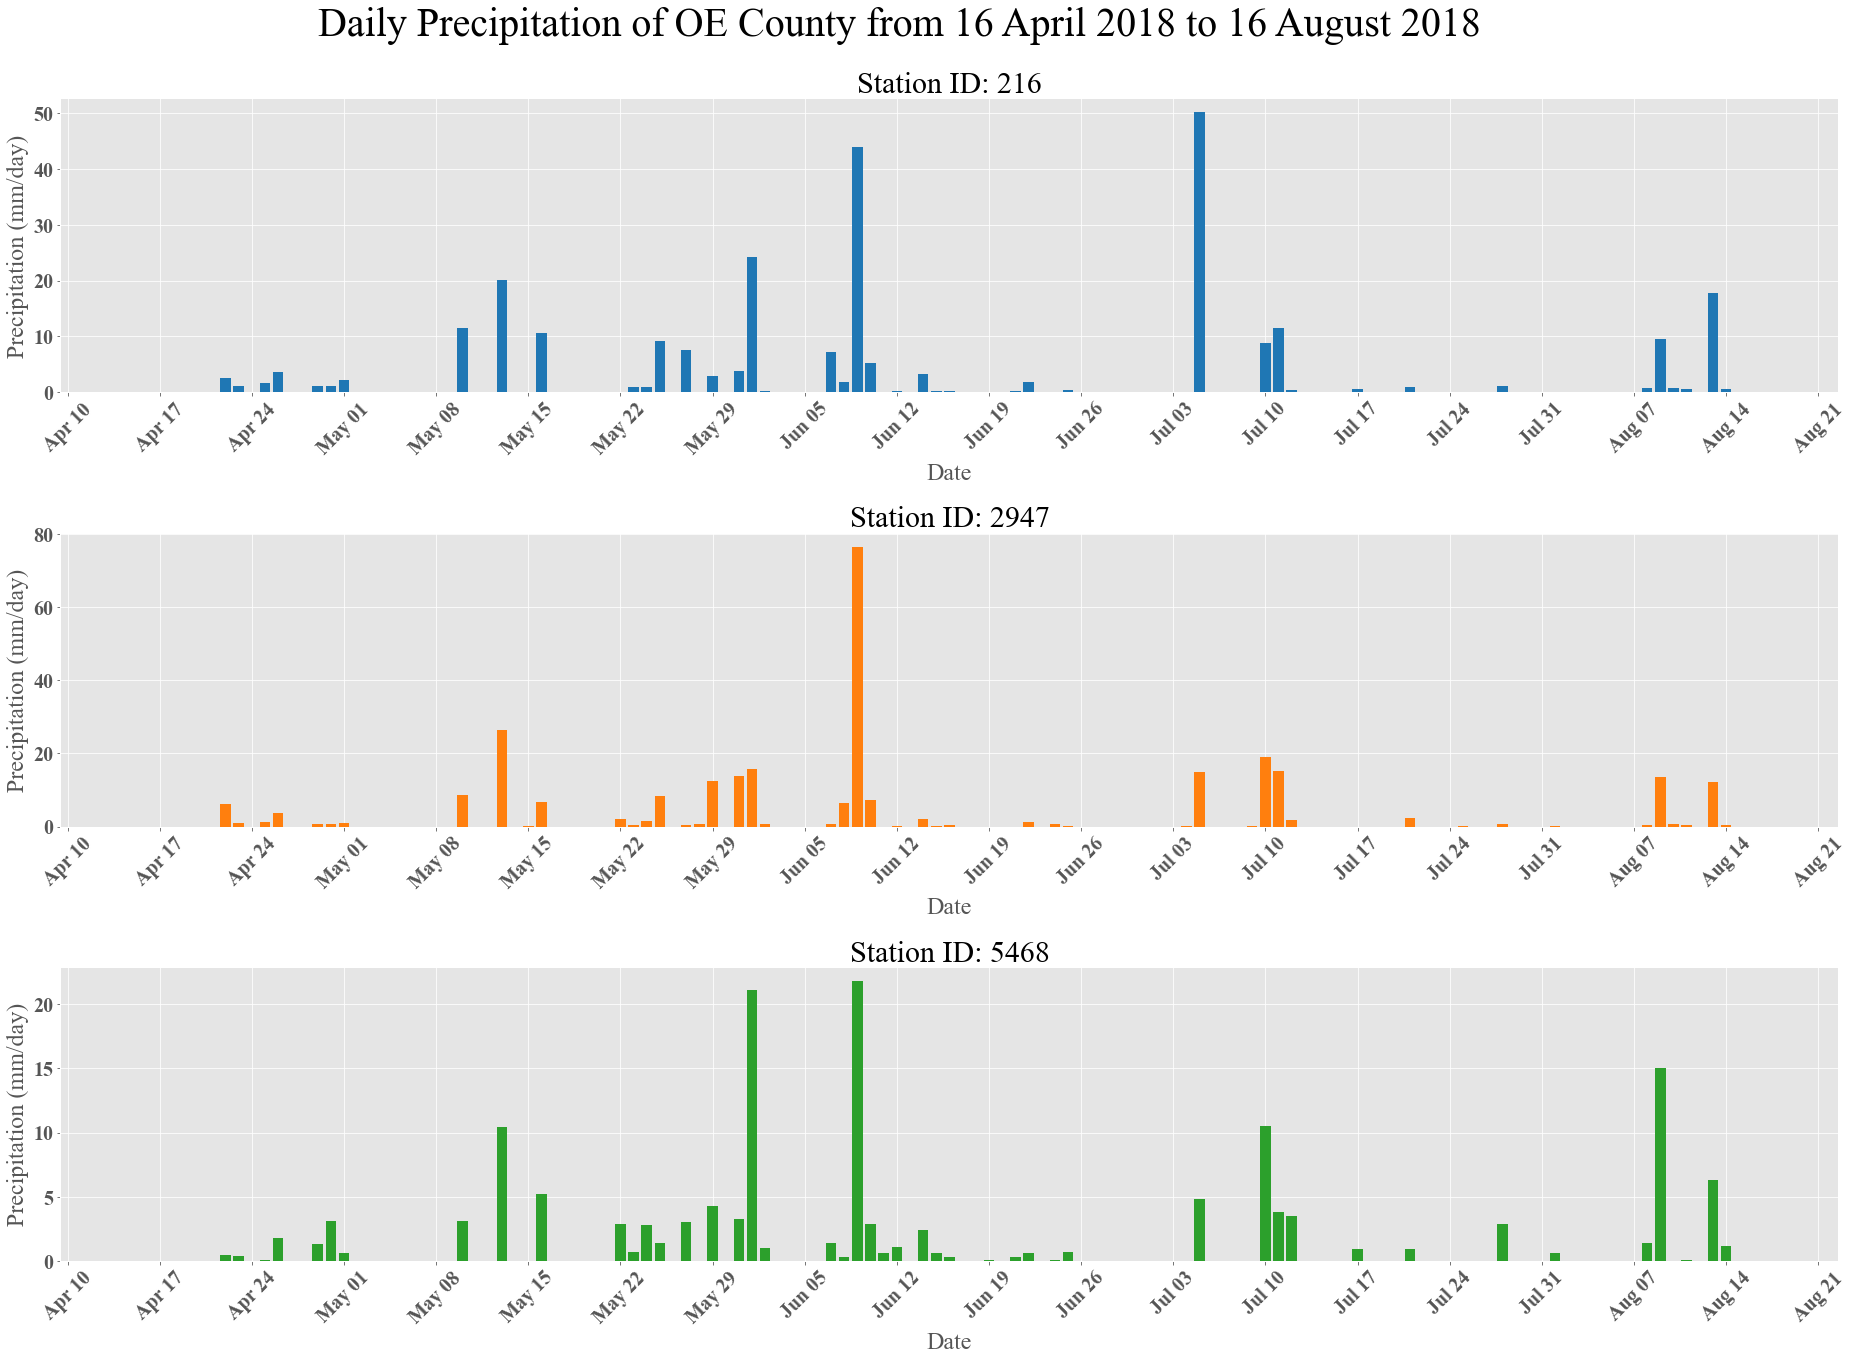

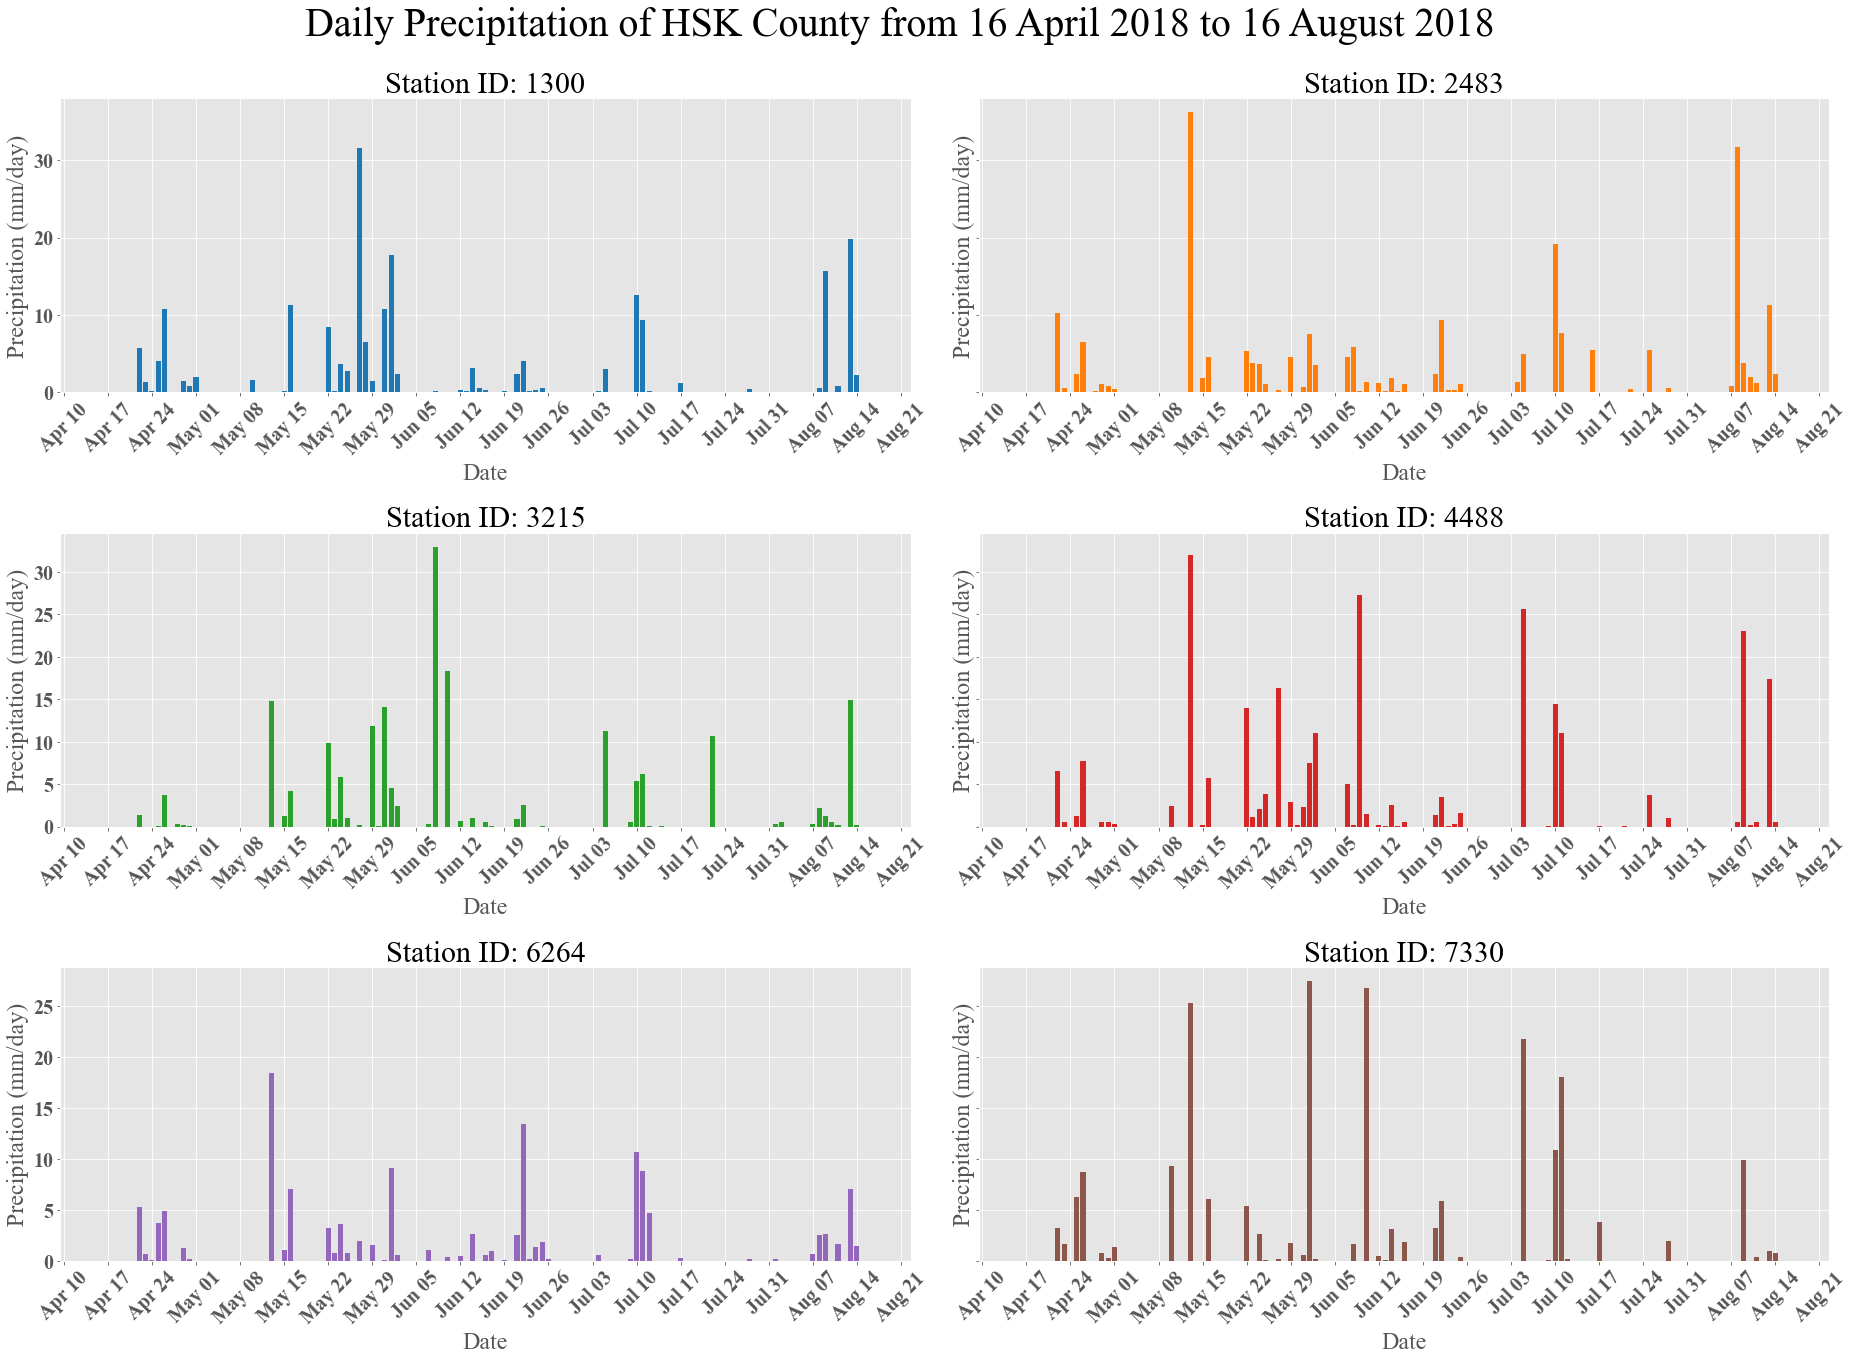

In [30]:
# Plot precipitation rate (for each station) for Olpe (OE) and Hochsauerlandkreis (HSK) counties

def plot_ts_bars(df, county_name):
    plt.style.use('ggplot')
    font = {'family': 'Times New Roman', 'weight': 'bold', 'size': 20}
    plt.rc('font', **font)

    columns_num = int(len(df.columns) / 3)

    fig, ax = plt.subplots(3, columns_num, sharey='row', figsize=(27, 20))
    ax = ax.flatten()

    cmap = plt.get_cmap('tab10')
    colors = iter(cmap(np.arange(cmap.N)))

    for idx, column_name in enumerate(df.columns):
        ax[idx].bar(df.index, df[column_name], color=next(colors))
        # set ticks every week
        ax[idx].xaxis.set_major_locator(mdates.WeekdayLocator())
        # format date
        ax[idx].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        ax[idx].tick_params(axis='x', rotation=45)
        ax[idx].set_title('Station ID: ' + str(column_name), fontsize=30)
        ax[idx].set_ylabel('Precipitation (mm/day)')
        ax[idx].set_xlabel('Date')

    fig.tight_layout(rect=[0.03, 0.03, 1, 0.95])
    plt.suptitle('Daily Precipitation of ' + county_name +
                 ' County from 16 April 2018 to 16 August 2018', fontsize=40)

    plt.show()


plot_ts_bars(df_ts_oe_daily, 'OE')
plot_ts_bars(df_ts_hsk_daily, 'HSK')

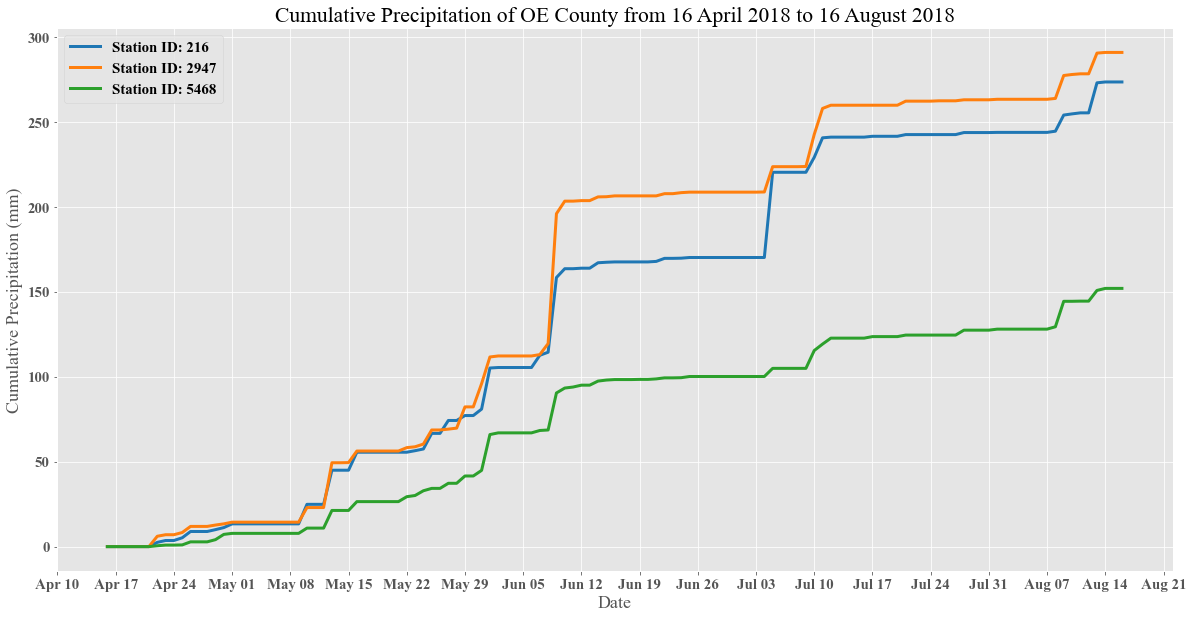

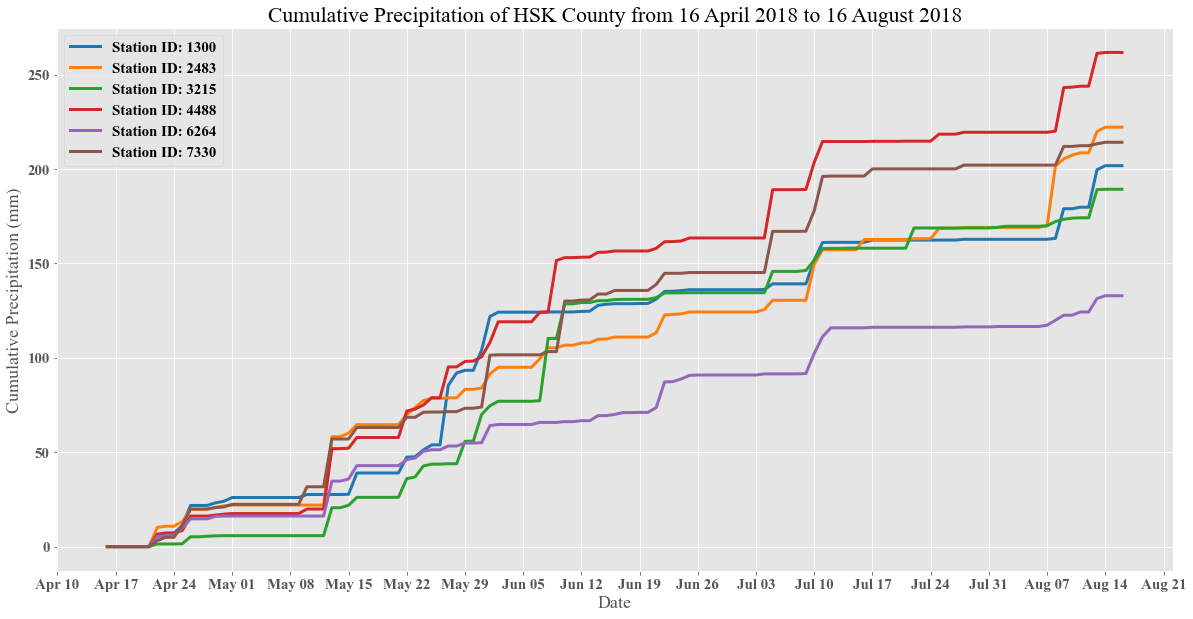

In [31]:
# Plot cumulative precipitation (for each station) for Olpe (OE) and Hochsauerlandkreis (HSK) counties

#df_ts_oe_daily_average['cumsum_daily_precp'] = df_ts_oe_daily_average['daily_precp'].cumsum(axis=0)

def plot_ts_cumsum_lines(df, county_name):

    df_cum_sum = df.cumsum(axis=0)

    plt.style.use('ggplot')
    font = {'family': 'Times New Roman', 'weight': 'bold', 'size': 15}
    plt.rc('font', **font)
    fig, ax = plt.subplots(figsize=(20, 10))

    cmap = plt.get_cmap('tab10')
    colors = iter(cmap(np.arange(cmap.N)))

    for column_name in df_cum_sum.columns:
        x = df_cum_sum.index
        y = df_cum_sum[column_name]
        ax.plot(x, y, color=next(colors), label='Station ID: ' + str(column_name), linewidth=3.0)

        # set ticks every week
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    # format date
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.set_title('Cumulative Precipitation of ' + county_name +
                     ' County from 16 April 2018 to 16 August 2018')
    ax.set_ylabel('Cumulative Precipitation (mm)')
    ax.set_xlabel('Date')
    ax.legend()
    plt.show()

    return df_cum_sum


df_ts_oe_cum_sum = plot_ts_cumsum_lines(df_ts_oe_daily, 'OE')
df_ts_hsk_cum_sum = plot_ts_cumsum_lines(df_ts_hsk_daily, 'HSK')

In [33]:
# Save generated dfs (that were used for plotting graphs) to csv
def save_dfs_to_csv(df, csv_name):
    filepathname = local_ts_appended_dir + csv_name
    print(csv_name + ' saved to: %s' % (filepathname))
    df.to_csv(filepathname, sep=";")


save_dfs_to_csv(df_ts_oe_daily, 'ts_oe_daily.csv')
save_dfs_to_csv(df_ts_hsk_daily, 'ts_hsk_daily.csv')

save_dfs_to_csv(df_ts_oe_cum_sum, 'ts_oe_cum_sum.csv')
save_dfs_to_csv(df_ts_hsk_cum_sum, 'ts_hsk_cum_sum.csv')

save_dfs_to_csv(df_ts_oe_daily_average_cumsum, 'ts_oe_daily_average_cumsum.csv')
save_dfs_to_csv(df_ts_hsk_daily_average_cumsum, 'ts_hsk_daily_average_cumsum.csv')



ts_oe_daily.csv saved to: ../data/generated/DWD//hourly/precipitation/historical/task4/ts_oe_daily.csv
ts_hsk_daily.csv saved to: ../data/generated/DWD//hourly/precipitation/historical/task4/ts_hsk_daily.csv
ts_oe_cum_sum.csv saved to: ../data/generated/DWD//hourly/precipitation/historical/task4/ts_oe_cum_sum.csv
ts_hsk_cum_sum.csv saved to: ../data/generated/DWD//hourly/precipitation/historical/task4/ts_hsk_cum_sum.csv
ts_oe_daily_average_cumsum.csv saved to: ../data/generated/DWD//hourly/precipitation/historical/task4/ts_oe_daily_average_cumsum.csv
ts_hsk_daily_average_cumsum.csv saved to: ../data/generated/DWD//hourly/precipitation/historical/task4/ts_hsk_daily_average_cumsum.csv
